# Régression logistique avec descente de gradient et calcul parallèle

In [2]:
library(readxl)
library(ggplot2)
library(devtools)

Loading required package: usethis



## Fonction sigmoide

$ \Large h(x) =  \frac{1}{1 + e^{-x} }  $  

![equation](https://latex.codecogs.com/png.latex?%5Clarge%20h%28x%29%20%3D%20%5Cfrac%7B1%7D%7B1%20&plus;%20e%5E%7B-x%7D%20%7D)

In [2]:
sigmoid <- function(x) {
    return(1 / (1 + exp(-x)))
}

## Modèle

$ \Large F(X) = X.\theta  $  
![equation](https://latex.codecogs.com/png.latex?%5Clarge%20F%28X%29%20%3D%20X.%5Ctheta)

In [4]:
x_dot_theta <- function(x, theta) {
    return(x %*% theta)
}

## Fonction de la régression logistique

$ \Large h_ \theta (x) =  \frac{1}{1 + e^{- X.\theta} }  $  
![equation](https://latex.codecogs.com/png.latex?%5Clarge%20h_%20%5Ctheta%20%28x%29%20%3D%20%5Cfrac%7B1%7D%7B1%20&plus;%20e%5E%7B-%20X.%5Ctheta%7D%20%7D)

In [9]:
probability <- function(x, theta) {
    return(sigmoid(x_dot_theta(x, theta)))
}

## Fonction de cout

$ \Large J(\theta) = -\frac{1}{m} \sum y \times log(\sigma(X.\theta)) + (1-y) \times (1-\sigma(X.\theta)) $  
![equation](https://latex.codecogs.com/png.latex?%5Clarge%20J%28%5Ctheta%29%20%3D%20-%5Cfrac%7B1%7D%7Bm%7D%20%5Csum%20y%20%5Ctimes%20log%28%5Csigma%28X.%5Ctheta%29%29%20&plus;%20%281-y%29%20%5Ctimes%20%281-%5Csigma%28X.%5Ctheta%29%29)

In [5]:
cost_function <- function(x, y, theta) {
    m <- nrow(y)
    g <- probability(x, theta)
    j <- (1 / m) * sum((-y * log(g)) - ((1 - y) * log(1 - g)))
    return(j)
}

## Calcul du gradient

$\Large \frac{\partial J(\theta) }{\partial \theta} = \frac{1}{m} X^T.(\sigma(X.\theta)-y)$  
![equation](https://latex.codecogs.com/gif.latex?%5Cfrac%7B%5Cpartial%20J%28%5Ctheta%29%20%7D%7B%5Cpartial%20%5Ctheta%7D%20%3D%20%5Cfrac%7B1%7D%7Bm%7D%20X%5ET.%28%5Csigma%28X.%5Ctheta%29-y%29)



In [11]:
# Gradient : calcul des dérivées partielles de chacun des paramètres de theta
gradient <- function(x, y, theta) {
    m <- nrow(y)
    return((1 / m) * x_dot_theta(t(x), probability(x, theta) - y))
}

## Descente de gradient

$\Large \theta = \theta - \alpha \frac{\partial J(\theta) }{\partial \theta}$  
![equation](https://latex.codecogs.com/png.latex?%5Clarge%20%5Ctheta%20%3D%20%5Ctheta%20-%20%5Calpha%20%5Cfrac%7B%5Cpartial%20J%28%5Ctheta%29%20%7D%7B%5Cpartial%20%5Ctheta%7D)




In [12]:
# Gradient descent
gradient_descent <- function(x, y, theta, learning_rate, n_iter, mode) {
    cost_history <- c(cost_function(x, y, theta))
    for (i in 1:n_iter) {
        # mise à jour des paramètres
        theta <- theta - learning_rate * gradient(x, y, theta)
        cost_history <- c(cost_history, cost_function(x, y, theta))
    }
    return(list(parameters = matrix(theta), cost_history = cost_history))
}

In [13]:
predict <- function(x, theta, thresold = 0.5) {
    predictions = unlist(ifelse(probability(x, theta) > thresold, 1, 0))
    return(predictions)
}

             [,1]
 [1,] -1.49365044
 [2,] -0.17879735
 [3,]  0.58378441
 [4,]  0.32219169
 [5,]  0.13097581
 [6,] -0.59470350
 [7,]  0.42949614
 [8,] -0.31954707
 [9,]  0.27257137
[10,] -0.09775771
  [1] 1.1905461 1.0786287 1.0300052 0.9865823 0.9472116 0.9114240 0.8788336
  [8] 0.8490929 0.8218895 0.7969440 0.7740083 0.7528630 0.7333149 0.7151943
 [15] 0.6983519 0.6826568 0.6679939 0.6542621 0.6413724 0.6292466 0.6178159
 [22] 0.6070194 0.5968037 0.5871214 0.5779305 0.5691940 0.5608785 0.5529544
 [29] 0.5453950 0.5381763 0.5312765 0.5246757 0.5183557 0.5122998 0.5064925
 [36] 0.5009196 0.4955678 0.4904246 0.4854786 0.4807188 0.4761350 0.4717178
 [43] 0.4674582 0.4633478 0.4593785 0.4555431 0.4518343 0.4482457 0.4447710
 [50] 0.4414044 0.4381404 0.4349737 0.4318994 0.4289131 0.4260103 0.4231870
 [57] 0.4204394 0.4177638 0.4151568 0.4126153 0.4101362 0.4077166 0.4053540
 [64] 0.4030457 0.4007893 0.3985827 0.3964236 0.3943101 0.3922403 0.3902123
 [71] 0.3882246 0.3862754 0.3843632 0.3824

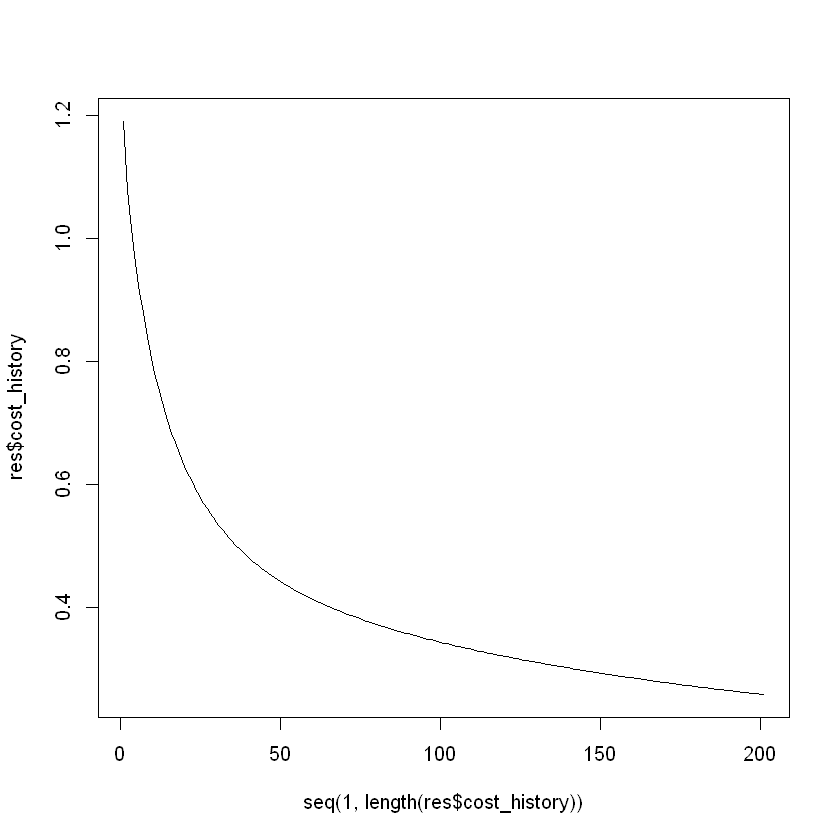

In [14]:
# test avec data_breast_cancer
data <- read_excel("breast.xlsx")
y <- data[, ncol(data)]
y <- ifelse(y == "malignant", 1, 0)


x <- data[, 1:(ncol(data) - 1)]

 # Ajout de la colonne de 1 pour faire le produit scalaire
x <- as.matrix(data.frame(rep(1, length(y)), x))

# Initialisation des paramètres theta
initial_theta <- as.matrix(rnorm(n = dim(x)[2], mean = 0, sd = 1))

# Entrainement
res <- gradient_descent(x, y, initial_theta, learning_rate = 0.1, n_iter = 200)
y_pred <- predict(x, res$parameters)

print(res$parameters)
print(res$cost_history)
plot(seq(1, length(res$cost_history)), res$cost_history, type = "l")

accuracy <- mean(y_pred == y)
print(accuracy)